In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset

import os
import time
import cv2
import random
import skimage
from skimage.util import random_noise
import numpy as np
from PIL import Image
from PIL import ImageFile
import matplotlib.pyplot as plt

In [2]:
len(os.listdir('/kaggle/input/wider-face/WIDER/train'))

28977

# Loss

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models


class VGG(nn.Module):
    def __init__(self, device):
        super(VGG, self).__init__()
        vgg = models.vgg19(True)
        for pa in vgg.parameters():
            pa.requires_grad = False
        self.vgg = vgg.features[:16]
        self.vgg = self.vgg.to(device)

    def forward(self, x):
        out = self.vgg(x)
        return out


class ContentLoss(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.mse = nn.MSELoss()
        self.vgg19 = VGG(device)

    def forward(self, fake, real):
        feature_fake = self.vgg19(fake)
        feature_real = self.vgg19(real)
        loss = self.mse(feature_fake, feature_real)
        return loss


class AdversarialLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        loss = torch.sum(-torch.log(x))
        return loss

class PerceptualLoss(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.vgg_loss = ContentLoss(device)
        self.adversarial = AdversarialLoss()

    def forward(self, fake, real, x):
        vgg_loss = self.vgg_loss(fake, real)
        adversarial_loss = self.adversarial(x)
        return vgg_loss + 1e-3*adversarial_loss


class RegularizationLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        a = torch.square(
            x[:, :, :x.shape[2]-1, :x.shape[3]-1] - x[:, :, 1:x.shape[2], :x.shape[3]-1]
        )
        b = torch.square(
            x[:, :, :x.shape[2]-1, :x.shape[3]-1] - x[:, :, :x.shape[2]-1, 1:x.shape[3]]
        )
        loss = torch.sum(torch.pow(a+b, 1.25))
        return loss

# Early Stopping

In [4]:
import numpy as np
import torch


class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_psnr_min = 0
        self.delta = delta
        self.checkpoint_perf = []

    def __call__(self, g, d, train_psnr, val_psnr):

        score = val_psnr
        self.early_stop = False

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(g, d, val_psnr)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                self.counter = 0
                self.best_score = None
                self.val_psnr_min = 0
        else:
            self.best_score = score
            self.save_checkpoint(g, d, val_psnr)
            self.counter = 0
            self.checkpoint_perf = [train_psnr, val_psnr]
        return self.checkpoint_perf

    def save_checkpoint(self, g, d, val_psnr):
        self.val_psnr_min = val_psnr
        if self.verbose:
            print(f'Validation PSNR increased ({self.val_psnr_min:.6f} --> {val_psnr:.6f}).  Saving model ...')
            torch.save(g.state_dict(), 'Generator.pth')
            torch.save(d.state_dict(), 'Discriminator.pth')
        else:
            torch.save(g.state_dict(), 'Generator.pth')
            torch.save(d.state_dict(), 'Discriminator.pth')


# Dataset


In [5]:
n_blocks = 5
n_epochs = 100
batch_size = 128
train_path = '/kaggle/input/wider-face/WIDER/train/'
train_path_noise = '/kaggle/input/fgsm-noise/kaggle/working/data_fgsm/noised_images/train/'
val_path = '/kaggle/input/wider-face/WIDER/val/'
val_path_noise = '/kaggle/input/fgsm-noise/kaggle/working/data_fgsm/noised_images/val/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [6]:
randomcrop = transforms.RandomCrop(96)

In [7]:
def addGaussNoise(data, sigma):
    sigma2 = sigma**2 / (255 ** 2)
    noise = random_noise(data, mode='gaussian', var=sigma2, clip=True)
    return noise

In [8]:
class MyDataset(Dataset):
    def __init__(self, ori_path, noise_path, transform, sigma=35, ex=1):
        self.transform = transform
        self.sigma = sigma

        for _, _, files in os.walk(ori_path):
            self.ori_imgs = [ori_path + file for file in files if Image.open(ori_path + file).size >= (96,96)] * ex
        
#         for _, _, files in os.walk(noise_path):
#             self.n_imgs = [noise_path + file for file in files if Image.open(noise_path + file).size >= (96,96)] * ex
        np.random.shuffle(self.ori_imgs)

    def __getitem__(self, index):
        tempImg = self.ori_imgs[index]
        tempImg = Image.open(tempImg).convert('RGB')
        Img = np.array(self.transform(tempImg))/255
        nImg = addGaussNoise(Img, self.sigma)
#         noiseImg = self.n_imgs[index]
#         noiseImg = Image.open(noiseImg).convert('RGB')
#         nImg = np.array(self.transform(noiseImg))/255
        Img = torch.tensor(Img.transpose(2,0,1))
        nImg = torch.tensor(nImg.transpose(2,0,1))
        return Img, nImg

    def __len__(self):
        return len(self.ori_imgs)

In [9]:
def get_data(batch_size, train_path, val_path, transform, sigma, ex=1):
    train_dataset = MyDataset(train_path, train_path_noise, transform, sigma, ex)
    val_dataset = MyDataset(val_path, val_path_noise, transform, sigma, ex)
    train_iter = DataLoader(train_dataset, batch_size, drop_last=True, num_workers=6)
    val_iter = DataLoader(val_dataset, batch_size, drop_last=True, num_workers=6)
    return train_iter, val_iter

In [10]:
train_iter, val_iter = get_data(batch_size, train_path, val_path, randomcrop, sigma=50, ex=1)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
len(train_iter)

226

# Models

In [12]:
def calculate_psnr(img1, img2):
    return 10. * torch.log10(1. / torch.mean((img1 - img2) ** 2))

In [13]:
class ResBlock(nn.Module):
    def __init__(self, inC, outC):
        super(ResBlock, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(inC, outC, kernel_size=3, stride=1, padding=1, bias=False), 
                                    nn.BatchNorm2d(outC), 
                                    nn.PReLU())

        self.layer2 = nn.Sequential(nn.Conv2d(outC, outC, kernel_size=3, stride=1, padding=1, bias=False), 
                                    nn.BatchNorm2d(outC))

    def forward(self, x):
        resudial = x

        out = self.layer1(x)
        out = self.layer2(out)
        out = out + resudial

        return out

In [14]:
class Generator(nn.Module):
    def __init__(self, n_blocks):
        super(Generator, self).__init__()
        self.convlayer1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4, bias=False),
                                        nn.PReLU())

        self.ResBlocks = nn.ModuleList([ResBlock(64, 64) for _ in range(n_blocks)])

        self.convlayer2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False), 
                                        nn.BatchNorm2d(64))

        self.convout = nn.Conv2d(64, 3, kernel_size=9, stride=1, padding=4, bias=False)

    def forward(self, x):
        out = self.convlayer1(x)
        residual = out

        for block in self.ResBlocks:
            out = block(out)

        out = self.convlayer2(out)
        out = out + residual

        out = self.convout(out)

        return out

In [15]:
class DownSample(nn.Module):
    def __init__(self, input_channel, output_channel,  stride, kernel_size=3, padding=1):
        super(DownSample, self).__init__()
        self.layer = nn.Sequential(nn.Conv2d(input_channel, output_channel, kernel_size, stride, padding),
                                   nn.BatchNorm2d(output_channel),
                                   nn.LeakyReLU(inplace=True))

    def forward(self, x):
        x = self.layer(x)
        return x

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3, 64, 3, stride=1, padding=1),
                                   nn.LeakyReLU(inplace=True))

        self.down = nn.Sequential(DownSample(64, 64, stride=2, padding=1),
                                  DownSample(64, 128, stride=1, padding=1),
                                  DownSample(128, 128, stride=2, padding=1),
                                  DownSample(128, 256, stride=1, padding=1),
                                  DownSample(256, 256, stride=2, padding=1),
                                  DownSample(256, 512, stride=1, padding=1),
                                  DownSample(512, 512, stride=2, padding=1))

        self.dense = nn.Sequential(nn.AdaptiveAvgPool2d(1),
                                   nn.Conv2d(512, 1024, 1),
                                   nn.LeakyReLU(inplace=True),
                                   nn.Conv2d(1024, 1, 1),
                                   nn.Sigmoid())

    def forward(self, x):
        x = self.conv1(x)
        x = self.down(x)
        x = self.dense(x)
        return x

# Train & Eval

In [17]:
def train(generator, discriminator, train_iter, val_iter, n_epochs, optimizer_g, optimizer_d, loss_g, loss_d, Regulaztion, device):
    print('train on',device)
    generator.to(device)
    discriminator.to(device)
    cuda = next(generator.parameters()).device
    for epoch in range(n_epochs):
        train_epoch_loss_g = []
        train_epoch_loss_d = []
        train_epoch_psnr = []
        val_epoch_loss = []
        val_epoch_psnr = []
        start = time.time()
        generator.train()
        discriminator.train()
        for i, (img, nimg) in enumerate(train_iter):
            img, nimg = img.to(cuda).float(), nimg.to(cuda).float()
            fakeimg = generator(nimg)
            
            optimizer_d.zero_grad()
            realOut = discriminator(img)
            fakeOut = discriminator(fakeimg.detach())
            loss_d = D_loss(realOut, real_label) + D_loss(fakeOut, fake_label)
            loss_d.backward()
            optimizer_d.step()
            
            optimizer_g.zero_grad()
            loss_g = G_loss(fakeimg, img, D(fakeimg)) + 2e-8*Regulaztion(fakeimg)
            loss_g.backward()
            optimizer_g.step()
            
            train_epoch_loss_d.append(loss_d.item())
            train_epoch_loss_g.append(loss_g.item())
            train_epoch_psnr.append(calculate_psnr(fakeimg, img).item())
        train_epoch_avg_loss_g = np.mean(train_epoch_loss_g)
        train_epoch_avg_loss_d = np.mean(train_epoch_loss_d)
        train_epoch_avg_psnr = np.mean(train_epoch_psnr)
        train_loss_g.append(train_epoch_avg_loss_g)
        train_loss_d.append(train_epoch_avg_loss_d)
        train_psnr.append(train_epoch_avg_psnr)
        print(f'Epoch {epoch + 1}, Generator Train Loss: {train_epoch_avg_loss_g:.4f}, '
              f'Discriminator Train Loss: {train_epoch_avg_loss_d:.4f}, PSNR: {train_epoch_avg_psnr:.4f}')
        generator.eval()
        discriminator.eval()
        with torch.no_grad():
            for i, (img, nimg) in enumerate(val_iter):
                img, nimg = img.to(cuda).float(), nimg.to(cuda).float()
                fakeimg = generator(nimg)
                loss_g = G_loss(fakeimg, img, D(fakeimg)) + 2e-8*Regulaztion(fakeimg)
                val_epoch_loss.append(loss_g.item())
                val_epoch_psnr.append(calculate_psnr(fakeimg, img).item())
            val_epoch_avg_loss = np.mean(val_epoch_loss)
            val_epoch_avg_psnr = np.mean(val_epoch_psnr)
            val_loss.append(val_epoch_avg_loss)
            val_psnr.append(val_epoch_avg_psnr)
            print(f'Generator Val Loss: {val_epoch_avg_loss:.4f}, PSNR: {val_epoch_avg_psnr:.4f}, Cost: {(time.time()-start):.4f}s')
            checkpoint_perf = early_stopping(generator, discriminator, train_epoch_avg_psnr, val_epoch_avg_psnr)
            if early_stopping.early_stop:
                print("Early stopping")
                print('Final model performance:')
                print(f'Train PSNR: {checkpoint_perf[0]}, Val PSNR: {checkpoint_perf[1]}')
                break
        torch.cuda.empty_cache()

In [18]:
    lr = 0.00001

    G = Generator(n_blocks)
    D = Discriminator()

    G_loss = PerceptualLoss(device)
    Regulaztion = RegularizationLoss().to(device)
    D_loss = nn.BCELoss().to(device)

    # Load pretrained models
    genPath = "/kaggle/working/Generator.pth"
    disPath = "/kaggle/working/Discriminator.pth"

    if os.path.exists(genPath) and os.path.exists(disPath):
        G.load_state_dict(torch.load("/kaggle/working/Generator.pth"))
        D.load_state_dict(torch.load("/kaggle/working/Discriminator.pth"))
        
    optimizer_g = torch.optim.Adam(G.parameters(), lr=lr*0.1)
    optimizer_d = torch.optim.Adam(D.parameters(), lr=lr)

    real_label = torch.ones([batch_size, 1, 1, 1]).to(device)
    fake_label = torch.zeros([batch_size, 1, 1, 1]).to(device)

    early_stopping = EarlyStopping(20, verbose=True)
    train_loss_g = []
    train_loss_d = []
    train_psnr = []
    val_loss = []
    val_psnr = []

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 94.0MB/s]


train on cuda
Epoch 1, Generator Train Loss: 8.4132, Discriminator Train Loss: 0.7107, PSNR: 3.7195
Generator Val Loss: 6.5316, PSNR: 4.4749, Cost: 301.8085s
Validation PSNR increased (4.474893 --> 4.474893).  Saving model ...
Epoch 2, Generator Train Loss: 5.9998, Discriminator Train Loss: 0.1644, PSNR: 4.8708
Generator Val Loss: 5.1309, PSNR: 5.3864, Cost: 294.7371s
Validation PSNR increased (5.386391 --> 5.386391).  Saving model ...
Epoch 3, Generator Train Loss: 5.0510, Discriminator Train Loss: 0.0566, PSNR: 5.7449
Generator Val Loss: 4.3197, PSNR: 6.2539, Cost: 296.0331s
Validation PSNR increased (6.253938 --> 6.253938).  Saving model ...
Epoch 4, Generator Train Loss: 4.4224, Discriminator Train Loss: 0.0260, PSNR: 6.5742
Generator Val Loss: 3.7115, PSNR: 7.0353, Cost: 295.2639s
Validation PSNR increased (7.035346 --> 7.035346).  Saving model ...
Epoch 5, Generator Train Loss: 4.0257, Discriminator Train Loss: 0.0142, PSNR: 7.3176
Generator Val Loss: 3.3169, PSNR: 7.7181, Cost: 

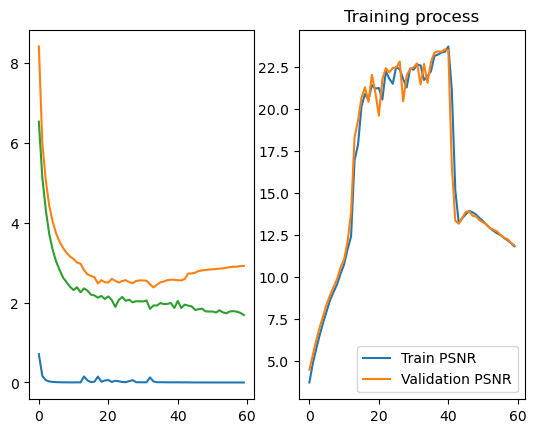

In [19]:
train(G, D, train_iter, val_iter, n_epochs, optimizer_g, optimizer_d, G_loss, D_loss, Regulaztion, device)
    
plt.figure()
plt.subplot(1,2,1)
plt.plot(train_loss_d, label='Generator Train Loss')
plt.plot(train_loss_g, label='Discriminator Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.subplot(1,2,2)
plt.plot(train_psnr, label='Train PSNR')
plt.plot(val_psnr, label='Validation PSNR')
plt.title('Training process')
plt.legend()
plt.show()

# Test only

In [20]:
model = Generator(n_blocks)
model.load_state_dict(torch.load('/kaggle/working/Generator.pth', map_location=torch.device('cpu')))
model.eval()

Generator(
  (convlayer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4), bias=False)
    (1): PReLU(num_parameters=1)
  )
  (ResBlocks): ModuleList(
    (0-4): 5 x ResBlock(
      (layer1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
      )
      (layer2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (convlayer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convout): Conv2d(64, 3, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4), bias=False)
)

In [21]:
test_transform = transforms.ToTensor()
# testimg = Image.open('/kaggle/input/dsadasdaa/359926200_1080679019575320_4298271193912583206_n.png')


test = Image.open('/kaggle/input/wider-face/WIDER/val/0_Parade_Parade_0_164.jpg')
timg = np.array(test)/255
timg = addGaussNoise(timg, 50)
timg = torch.tensor(timg.transpose(2,0,1)).float().unsqueeze(0)

In [22]:
dnimg = model(timg)[0, :, :, :]
dnimg = dnimg.detach().numpy().transpose((1, 2, 0))

In [23]:
timg = Image.fromarray(np.uint8(cv2.normalize(timg.squeeze().detach().numpy().transpose(1,2,0), None, 0, 255, cv2.NORM_MINMAX)))
timg.save('/kaggle/working/noise.png')

In [24]:
img = Image.fromarray(np.uint8(cv2.normalize(dnimg, None, 0, 255, cv2.NORM_MINMAX)))
img.save('/kaggle/working/denoised.png')

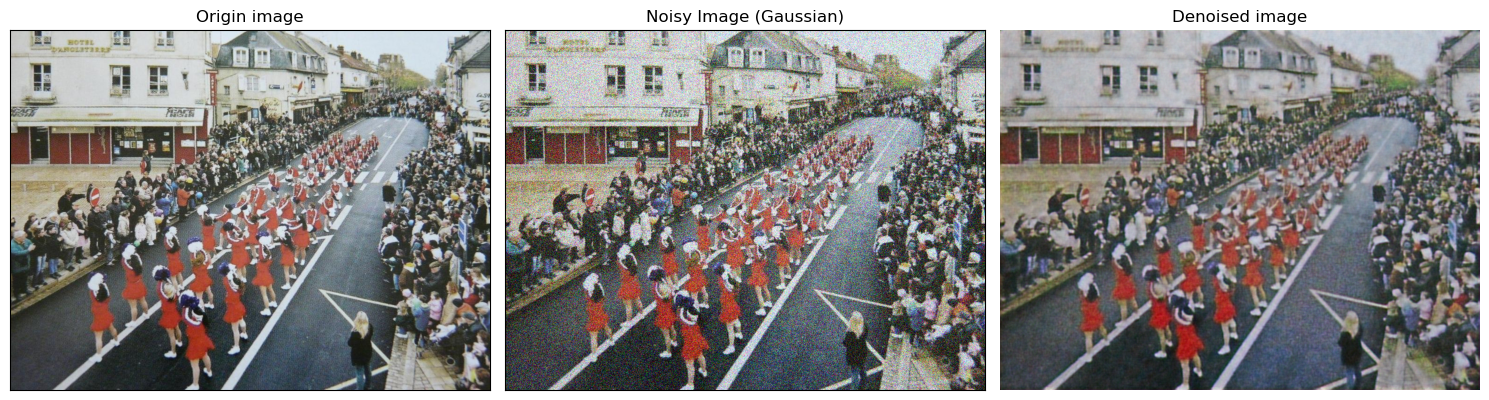

In [25]:
import matplotlib.pyplot as plt
import cv2

# Read the three images
image1 = cv2.imread('/kaggle/input/wider-face/WIDER/val/0_Parade_Parade_0_164.jpg')
image2 = cv2.imread('/kaggle/working/noise.png')
image3 = cv2.imread('/kaggle/working/denoised.png')

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display the first image
axes[0].imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
axes[0].set_title('Origin image',)
axes[0].set_xticks([])
axes[0].set_yticks([])
# Display the second image
axes[1].imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
axes[1].set_title('Noisy Image (Gaussian)')
axes[1].set_xticks([])
axes[1].set_yticks([])
# Display the third image
axes[2].imshow(cv2.cvtColor(image3, cv2.COLOR_BGR2RGB))
axes[2].set_title('Denoised image')
axes[2].set_xticks([])
axes[2].set_yticks([])
# Adjust spacing between subplots
plt.tight_layout()
plt.axis('off')

# Show the figure
plt.show()

fig.savefig('visualize.png')

# Reconstruct noisy dataset 

In [26]:
# outPath_ori = '/kaggle/working/output_file/origin'
# outPath_dn = '/kaggle/working/output_file/denoised'

# if not os.path.exists(outPath_ori):
#     os.makedirs(outPath_ori)
    
# if not os.path.exists(outPath_dn):
#     os.makedirs(outPath_dn)

In [27]:

# def restruct(model, input_path, output_dn):
#     for img in os.listdir(input_path):
#         img_path = os.path.join(input_path, img)
#         test = Image.open(img_path)
#         timg = np.array(test)/255
#         timg = addGaussNoise(timg, 30)
#         timg = torch.tensor(timg.transpose(2,0,1)).float().unsqueeze(0) 
#         dnimg = model(timg)[0, :, :, :]
#         dnimg = dnimg.detach().numpy().transpose((1, 2, 0))
#         img = Image.fromarray(np.uint8(cv2.normalize(dnimg, None, 0, 255, cv2.NORM_MINMAX)))
#         img.save(f'/kaggle/working/output_file/origin/{img}.png')

In [28]:
# restruct(model, '/kaggle/input/wider-face/WIDER/val' , outPath_dn)

In [29]:
# import matplotlib.pyplot as plt
# from skimage import io

# # Define the image paths
# image_paths = ['/kaggle/input/face-data/content/Yolo_1/images/val/00000020.jpg',
#                '/kaggle/working/noise.png',
#                '/kaggle/working/denoised.png']

# # Create a figure with 3 subplots
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# arr = ['original image', 'Noise image', 'denoised image']
# # Plot the histogram for each image
# for i, image_path in enumerate(image_paths):
#     # Load the image
#     image = io.imread(image_path)

#     # Plot the histogram for each color channel
#     colors = ('r', 'g', 'b')
#     for j, color in enumerate(colors):
#         axes[i].hist(image[..., j].ravel(), bins=256, color=color, alpha=0.5)
#     axes[i].set_title(f'Histogram of {arr[i]}')
    
#     # Hide the x and y ticks
#     axes[i].set_xticks([])
#     axes[i].set_yticks([])

# plt.tight_layout()
# plt.show()
# fig.savefig('histograms.png')